# Things that should only have to be defined once, here at the top
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from lmfit import Model, Parameters, CompositeModel
from lmfit.models import GaussianModel

from scipy.stats import chisquare
from scipy.integrate import trapz, simpson
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from astropy.io import fits

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458  # speed of light m/s

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x, ampl, center, std):
    return ((ampl) / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - center) / std) ** 2)) + 1

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA

# early_k = ('1', '2', '3', '4', '5')
# Only want to look at the K types for the moment
# standard_table_k = standard_table[standard_table['Spectral_Type'].str.startswith(('K1', 'K2', 'K5'))]

standard_shift = standard_table['Wavelength Shift'].values
standard_list = standard_table['Source'].values

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

hops_flux_length = max(len(fits.getdata(file)[1]) for file in hops_table['Source'])
hops_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_table['Source'])
hops_snr_length = max(len(fits.getdata(file)[2]) for file in hops_table['Source'])

# Initialize stacks with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)
raw_flux_err_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# hops_wavelen_stack = np.full((max_wavelen_length, len(hops_table)), np.nan)
# hops_raw_flux_stack = np.full((max_flux_length, len(hops_table)), np.nan)
# hops_snr_stack = np.full((max_snr_length, len(hops_table)), np.nan)
# hops_raw_flux_err_stack = np.full((max_snr_length, len(hops_table)), np.nan)


# Fill stacks with data
for i, file in enumerate(standard_list):
    # Get wavelength, flux, snr per resolution element data
    data = fits.getdata(file)
    wavelen, flux, snr = data[0], data[1], data[2]
    
    # Clean data a bit
    snr_min = 50  # Minimum SNR
    snr_max = 1e4  # Maximum SNR
    snr_cut = (snr > snr_min)  # & (snr < snr_max)  # Bitwise SNR masking

    flux_min = 10000  # Minimum flux
    flux_cut = flux > flux_min  # Bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    mask = flux_cut & snr_cut  & wavelen_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]

    # Remove NaNs and infs from wavelen, flux, and snr arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isnan(flux) & ~np.isnan(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i] # shift wavelengths by my very rough v/c calculation
    flux = flux[valid_indices]
    snr = snr[valid_indices]

    # Check for NaNs in the final arrays
    if np.any(np.isnan(wavelen)) or np.any(np.isnan(flux)) or np.any(np.isnan(snr)):
        print(f"NaNs found in data for file {file} after cleaning")

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux # savgol_filter(flux, window_length=11, polyorder=3)
    snr_stack[:len(snr), i] = snr
    raw_flux_err_stack[:len(flux), i] = flux / snr

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

## Na Interval ~2.21
Na I Doublet (2.2062, 2.2089) & Sc I (2.2058)

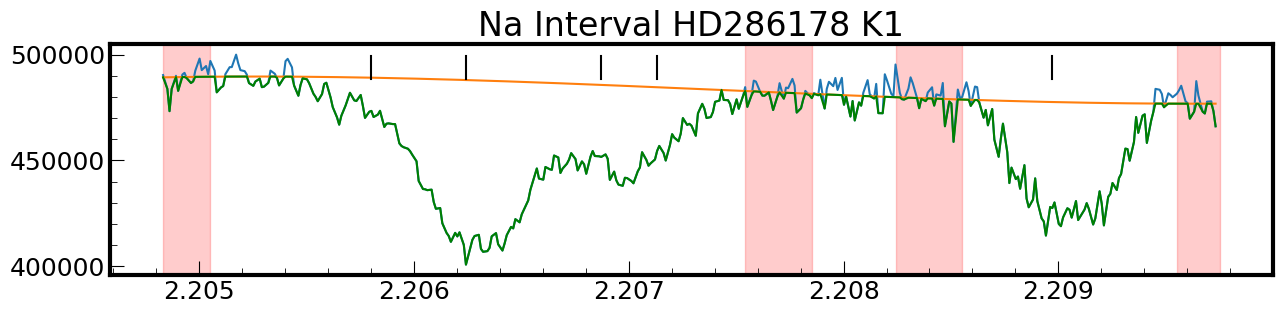

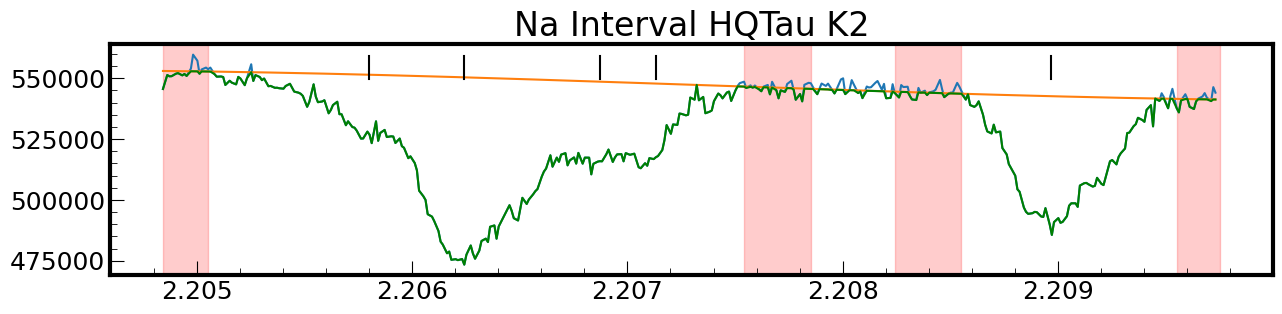

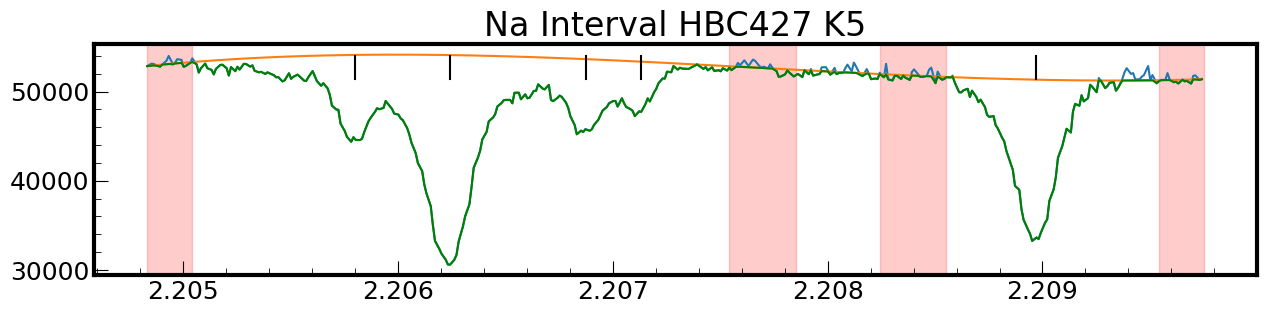

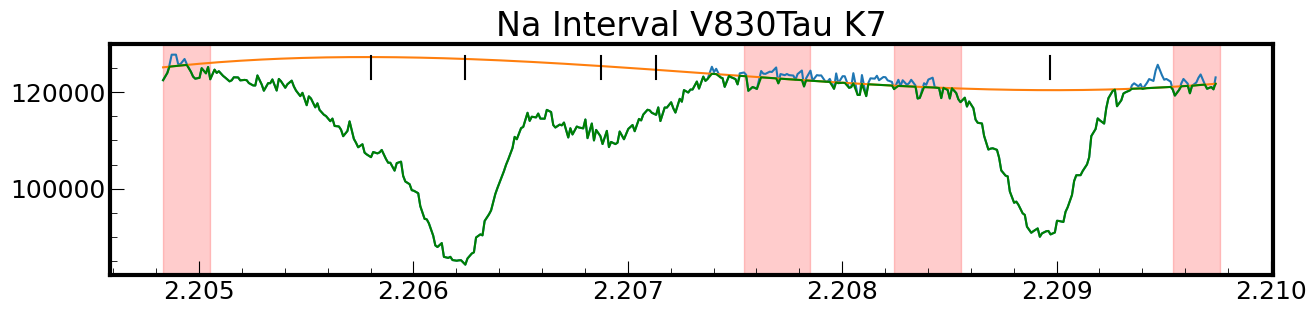

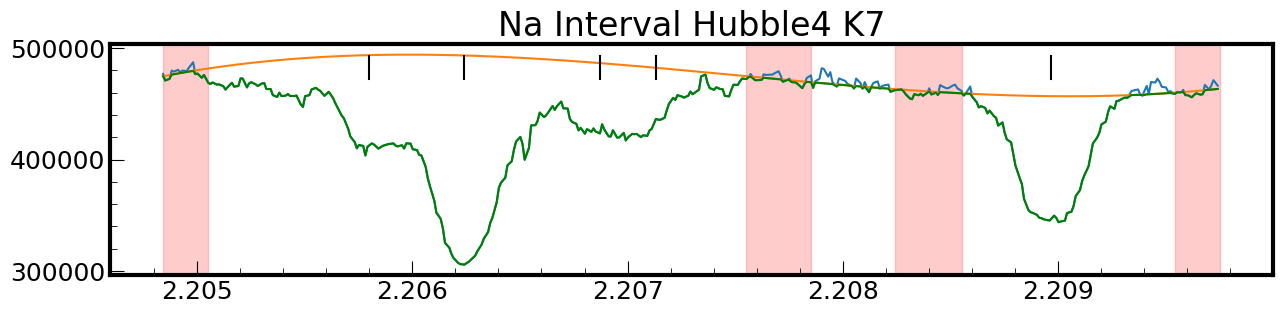

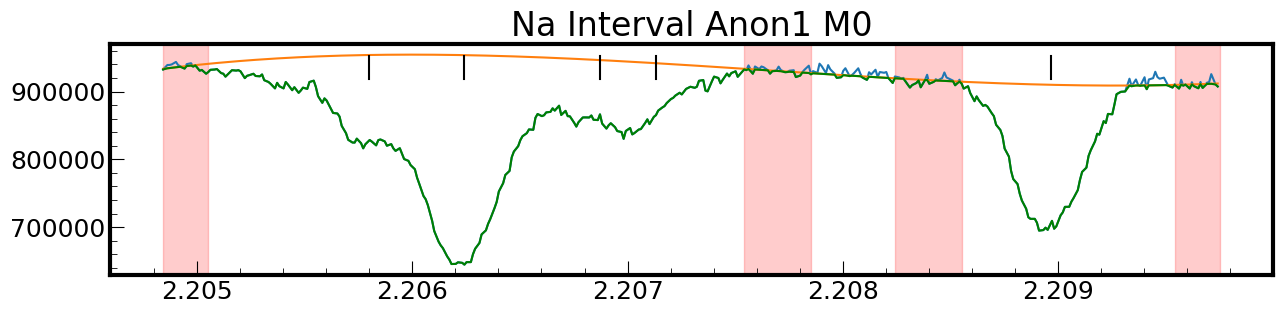

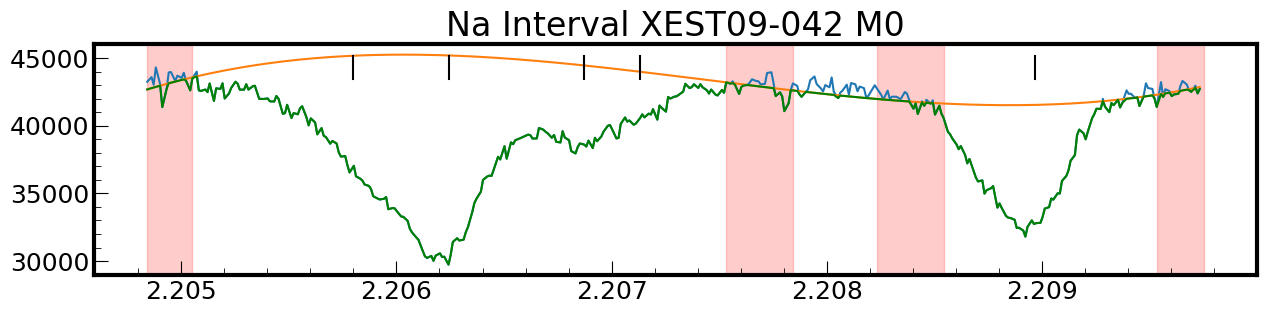

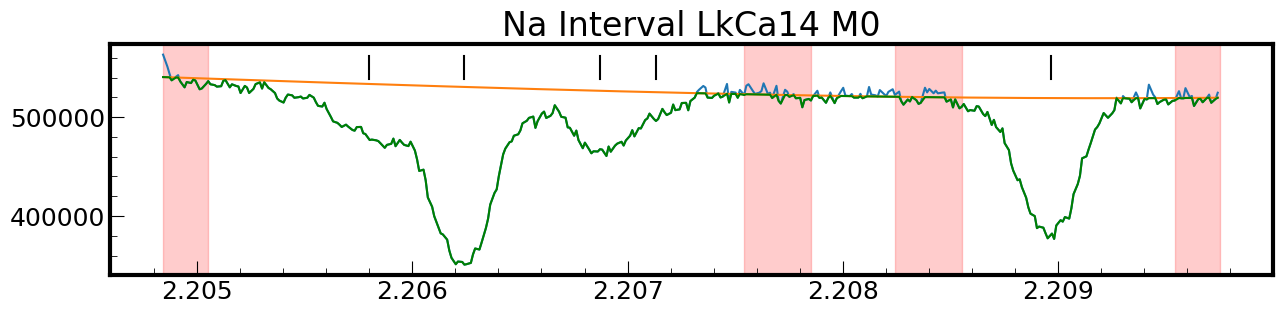

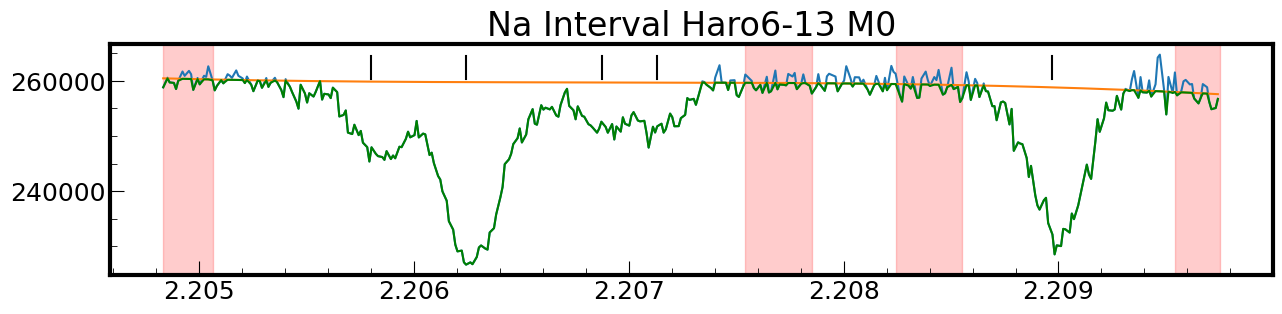

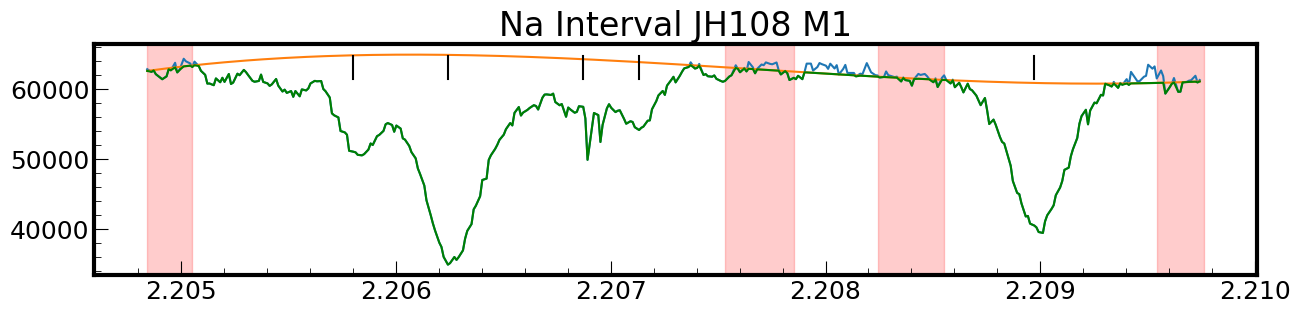

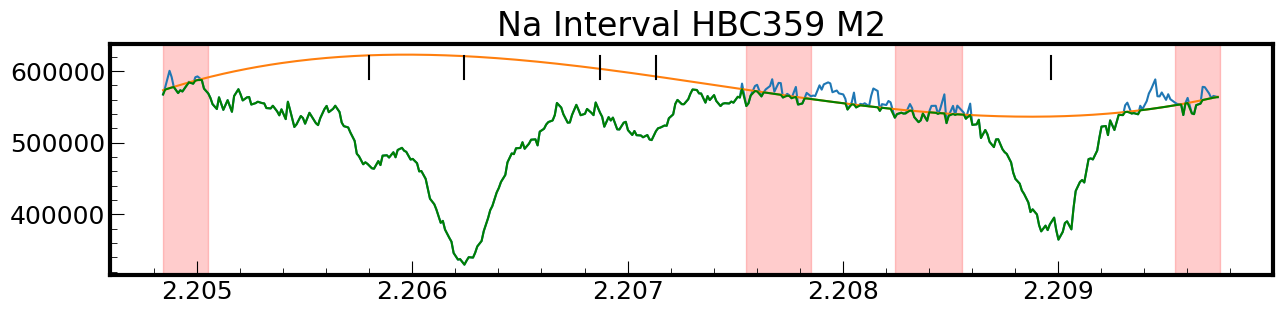

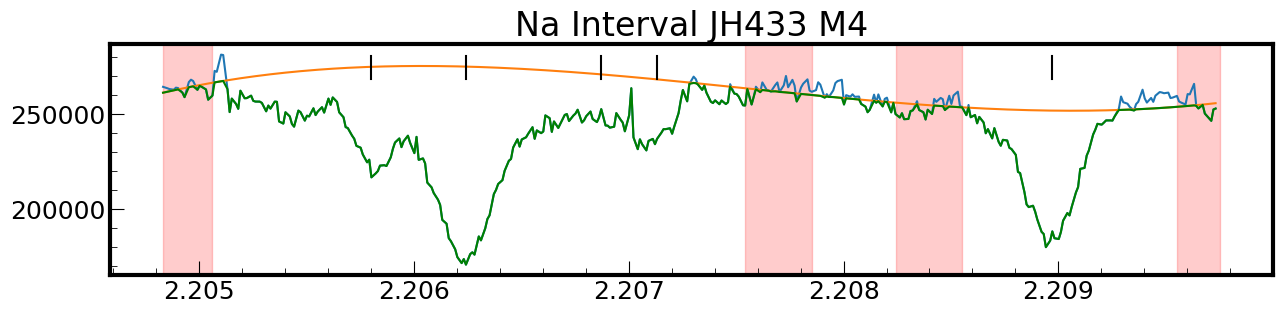

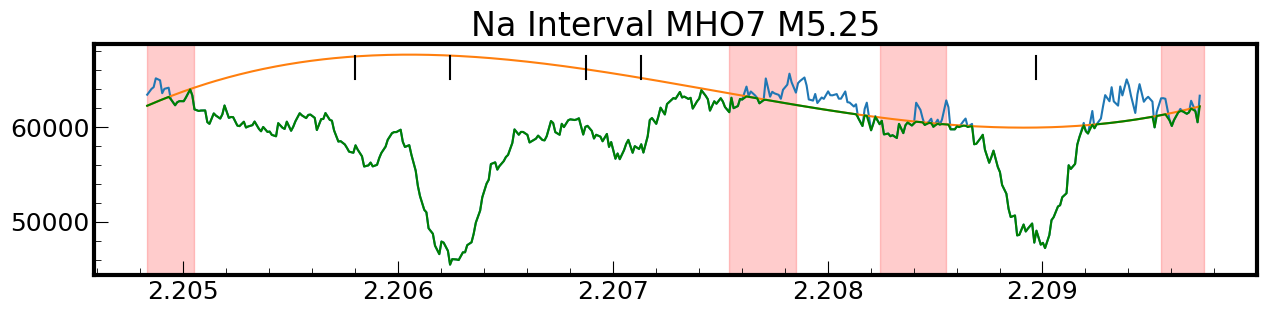

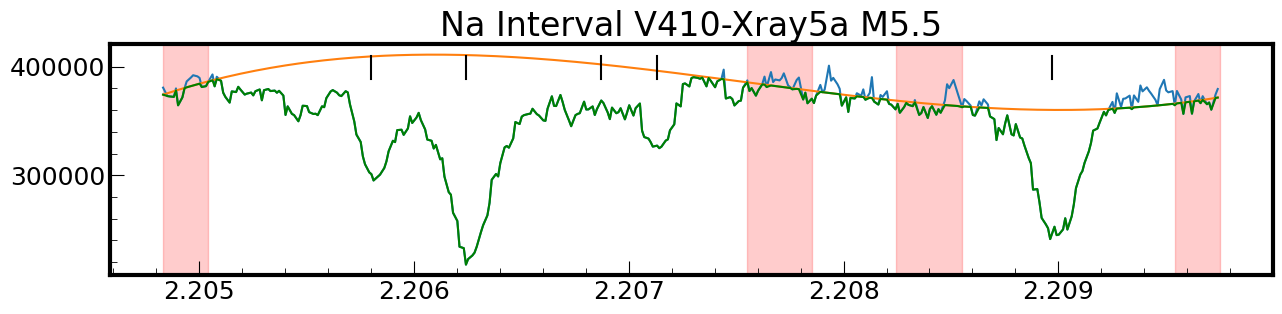

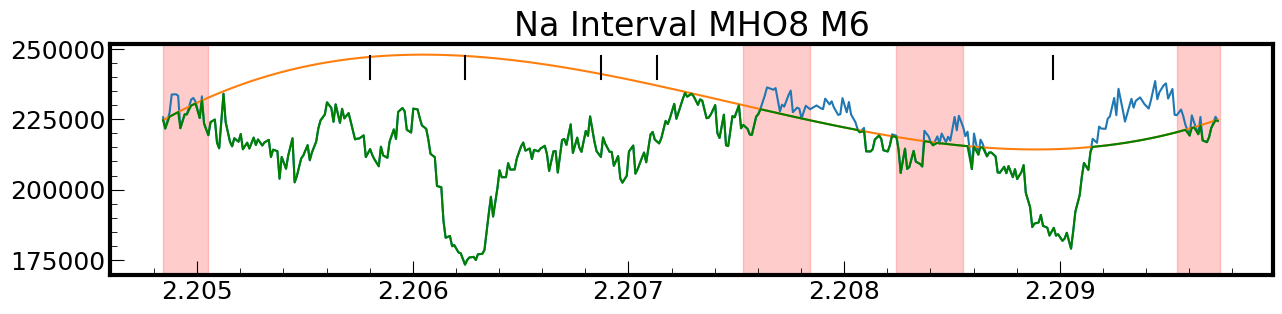

In [39]:
# Define the region for fitting
line_name = lines_table[na1_mask][0]['Spectrum'] # Species
line_center = lines_table[na1_mask][0]['Observed'] # Wavelength

na_reg_lines = sorted([lines_table[na1_mask][0]['Observed'],
                lines_table[sc1_mask][19]['Observed'],
                lines_table[si1_mask][2]['Observed'],
                lines_table[sc1_mask][20]['Observed'],
                lines_table[na1_mask][1]['Observed']])

# from igrins_mod import local_continuum_fit
continuum_stack = []
continuum_err_stack = []
norm_flux_stack = []
norm_flux_err_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-140,21),(130,31), (200,31),(330,21)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table)):
    fig = plt.figure(figsize=(15,3))
    continuum, continuum_err, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    raw_flux_err_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # Adjust flux values above the continuum
    adjusted_flux = np.minimum(raw_flux_stack[region_indices[0][0]:region_indices[n][1],i], continuum)
    
    # Normalize flux by dividing the adjusted flux by the continuum
    norm_flux = adjusted_flux / continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    
    # Plot the adjusted flux
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], adjusted_flux, linestyle='-', color='green')
    
    for j in range(len(region_indices)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)
    for k in range(len(na_reg_lines)):
        plt.axvline(na_reg_lines[k], ymin=0.85, ymax=0.95, color='black')

    plt.title(f"Na Interval {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.show()

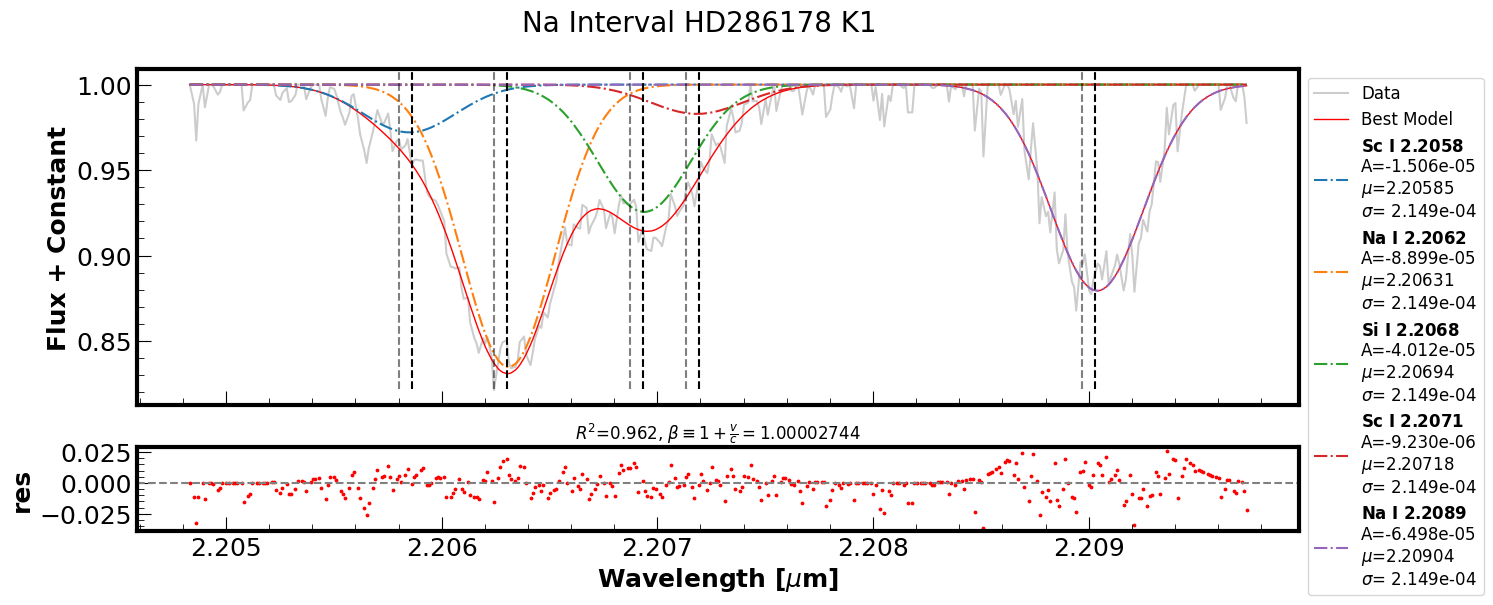

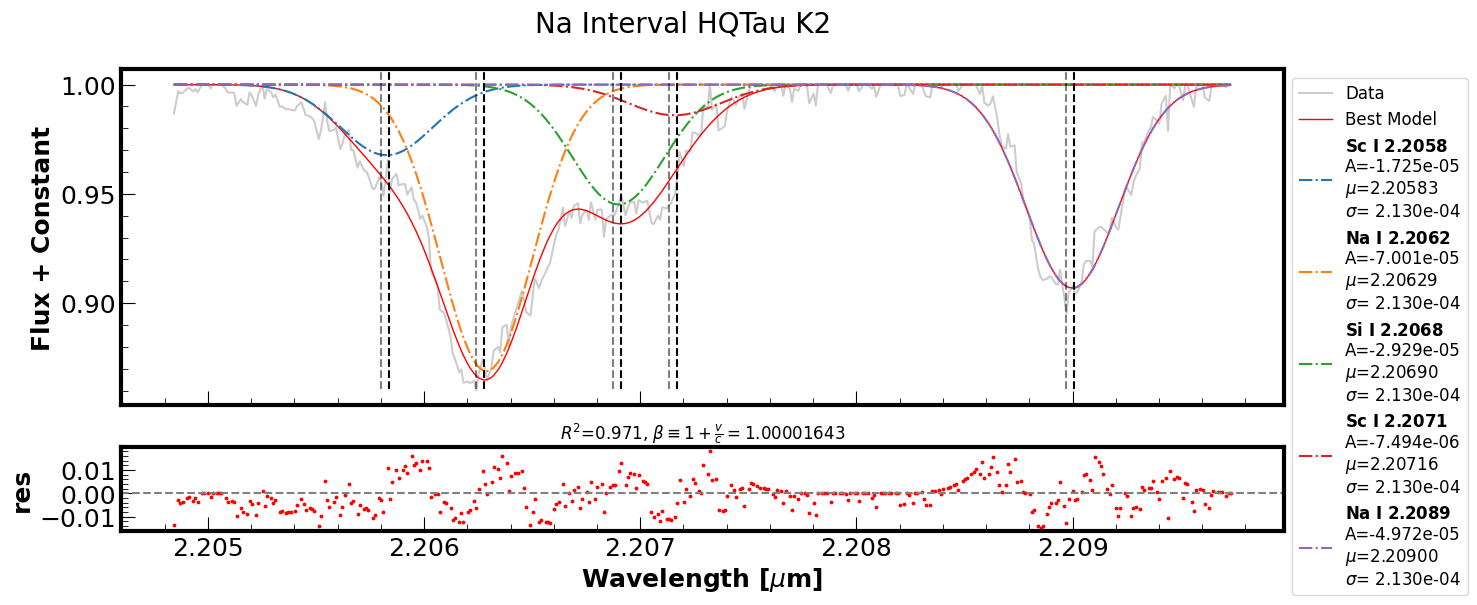

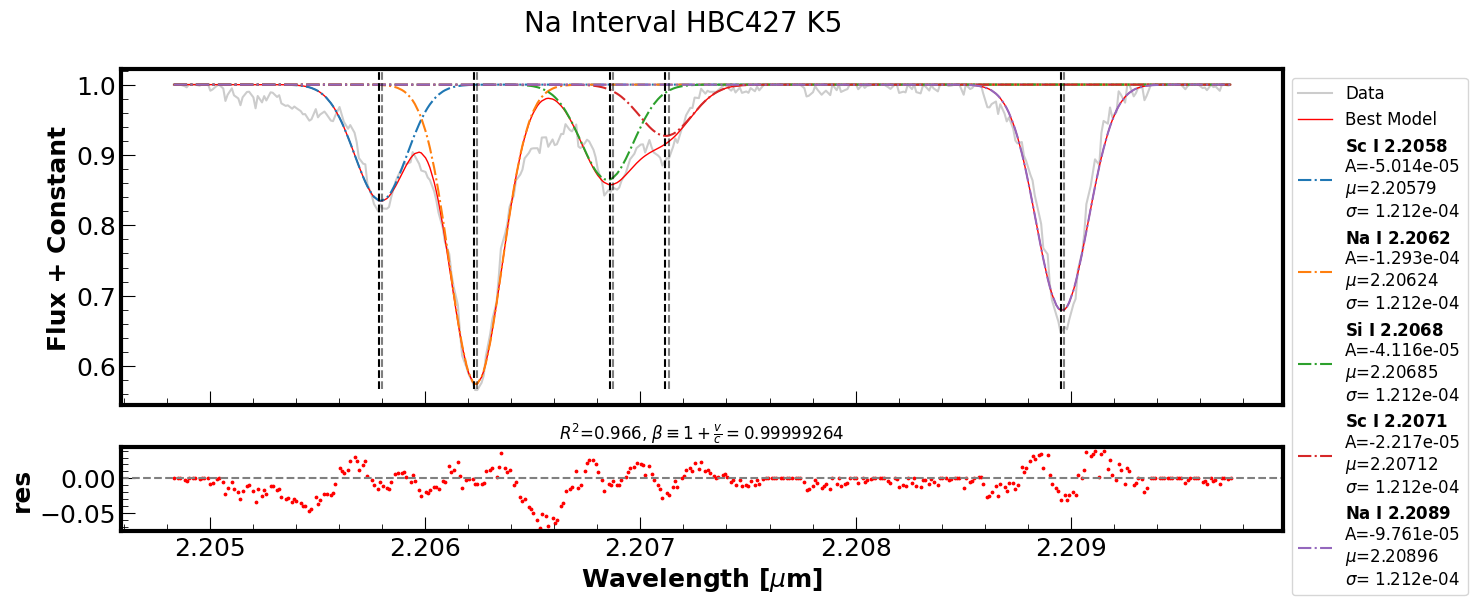

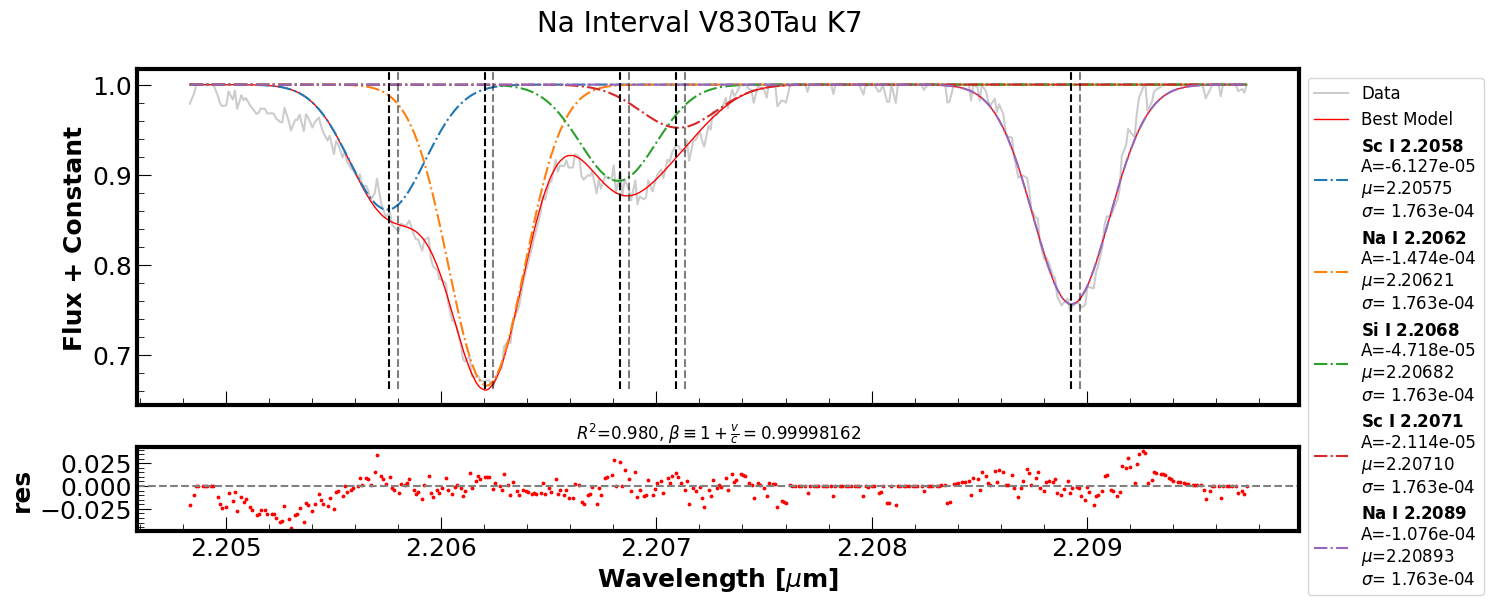

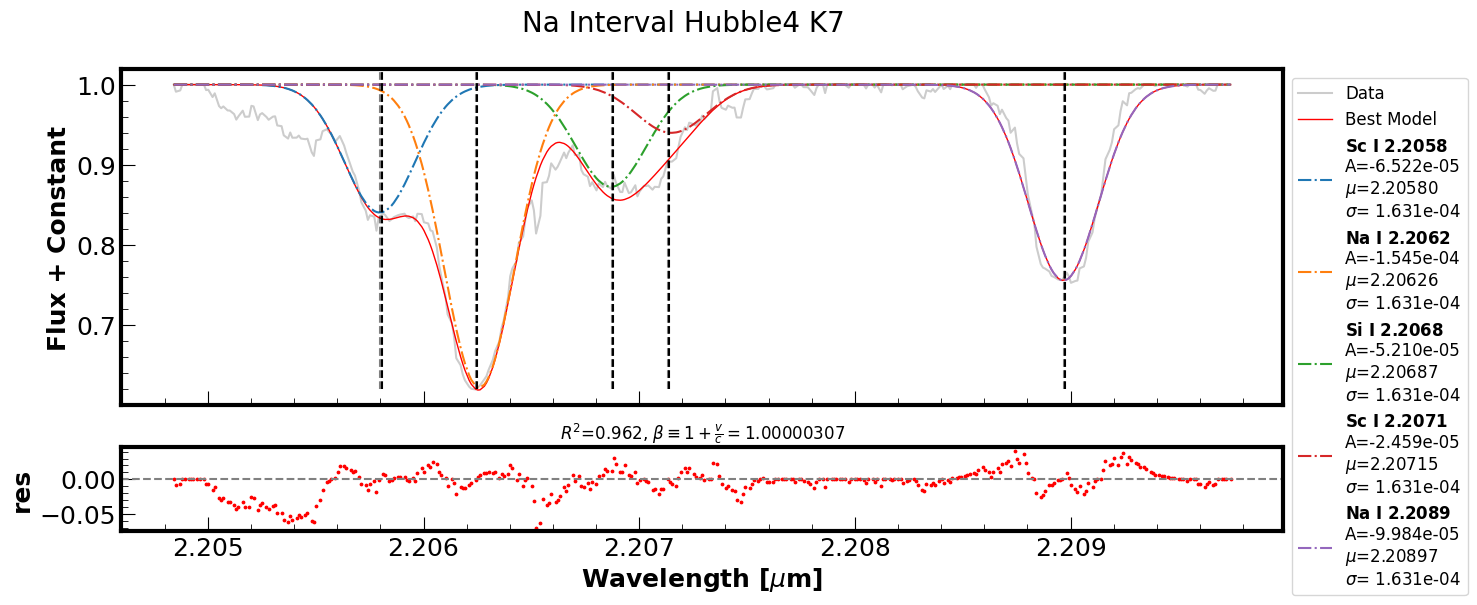

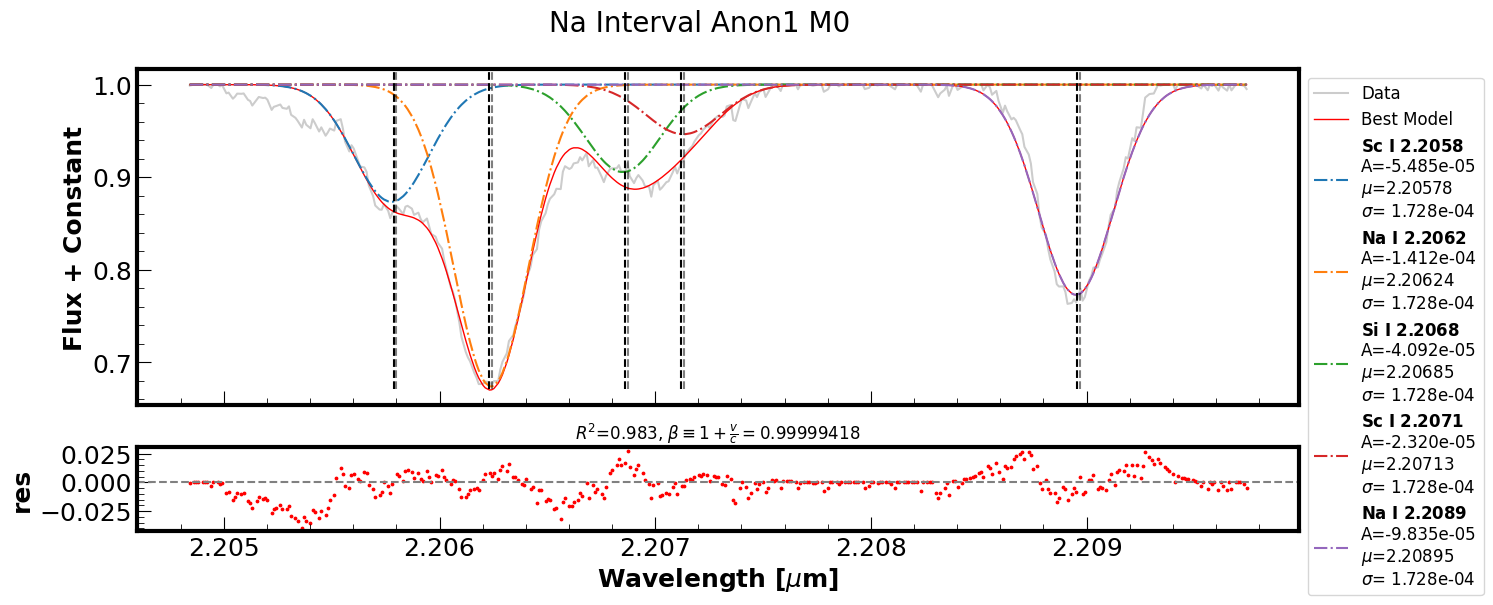

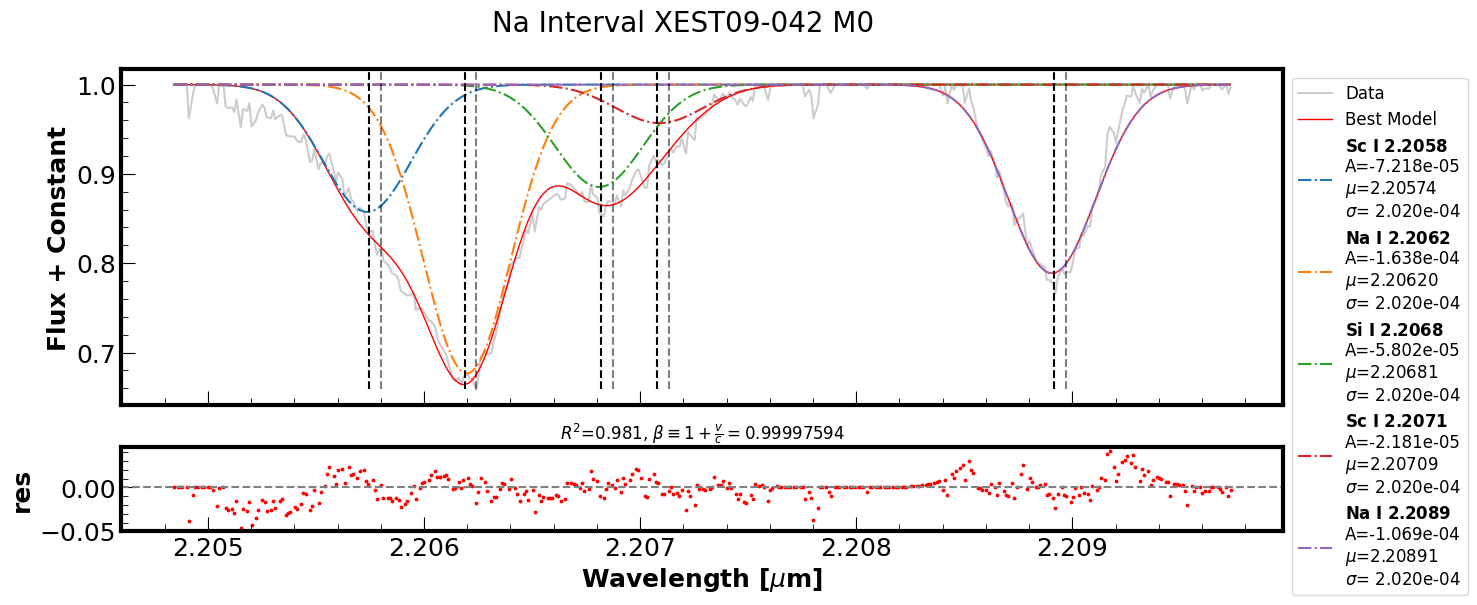

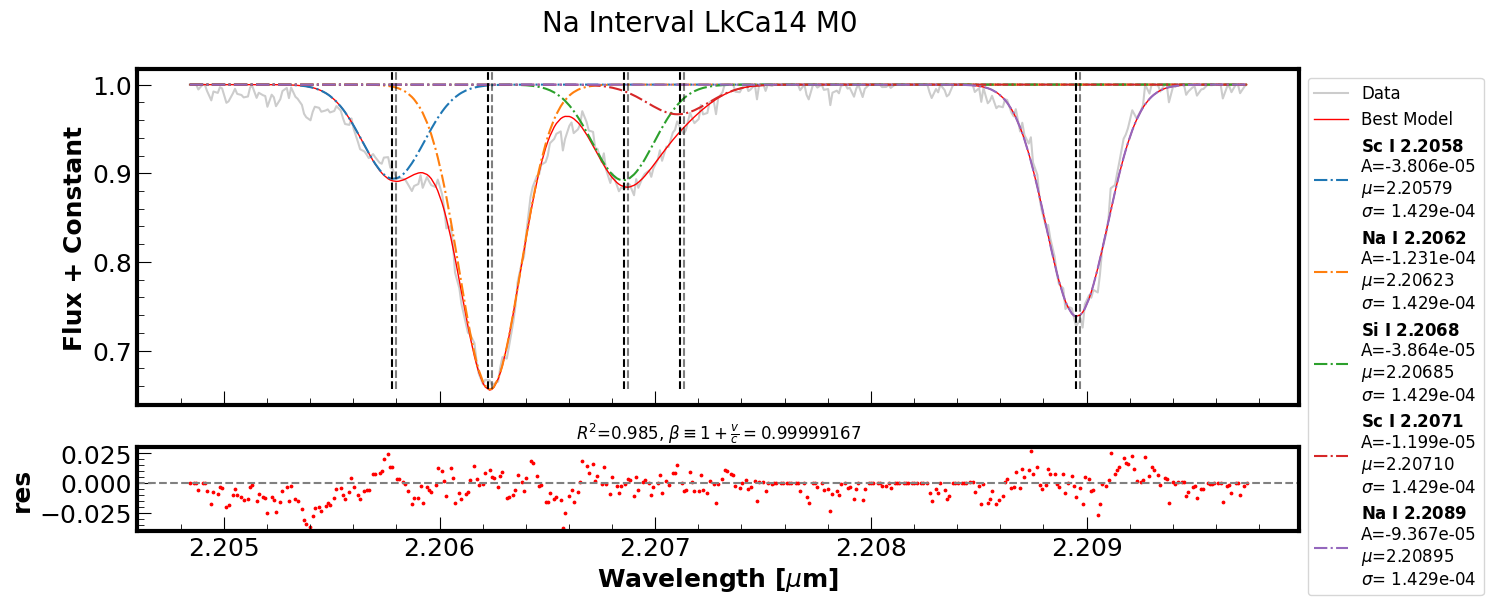

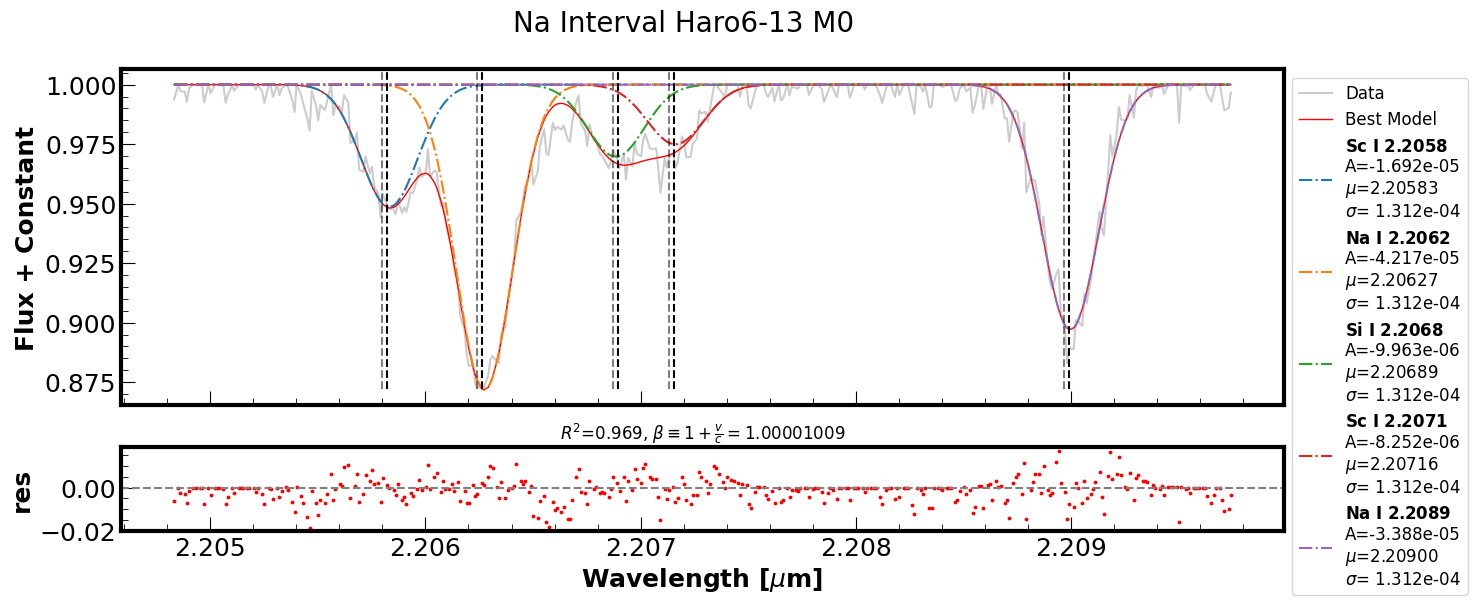

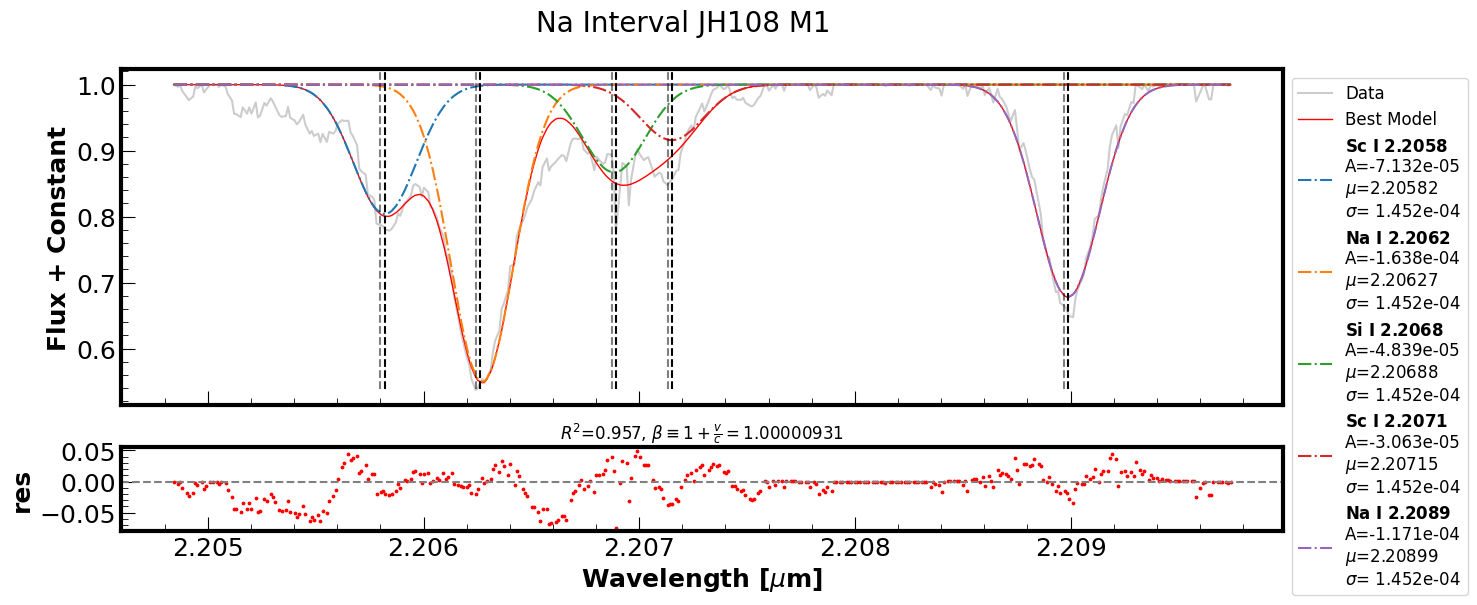

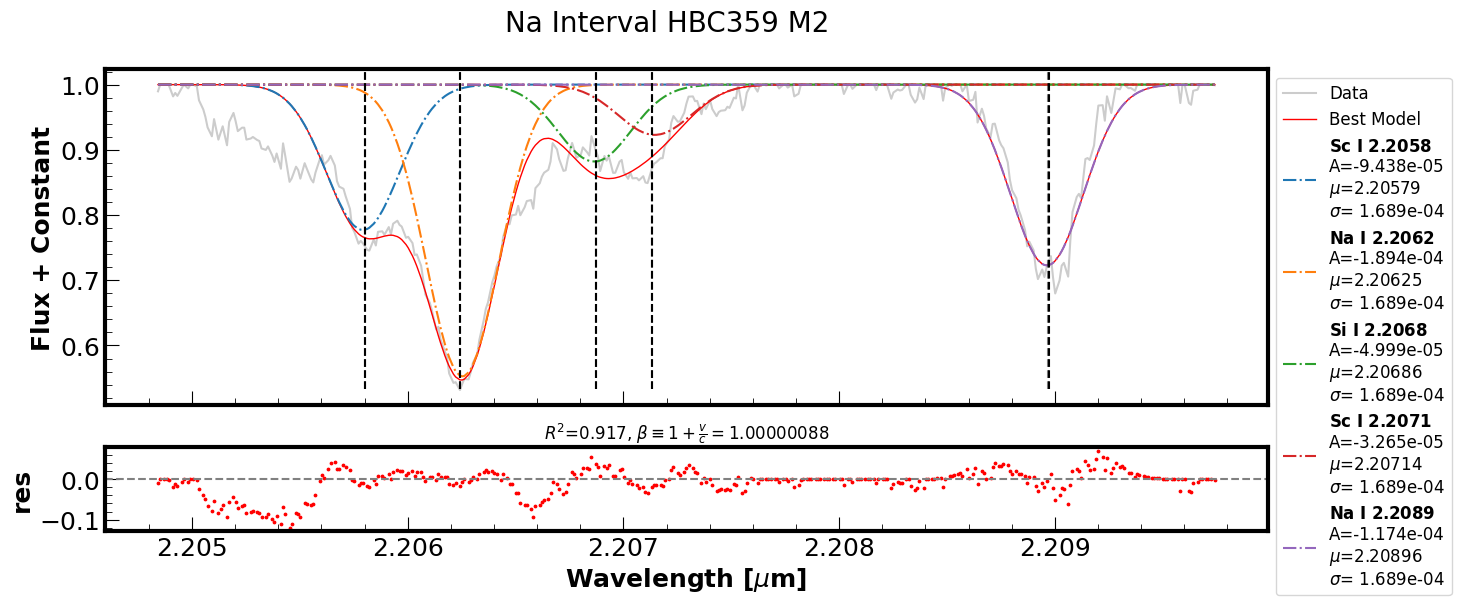

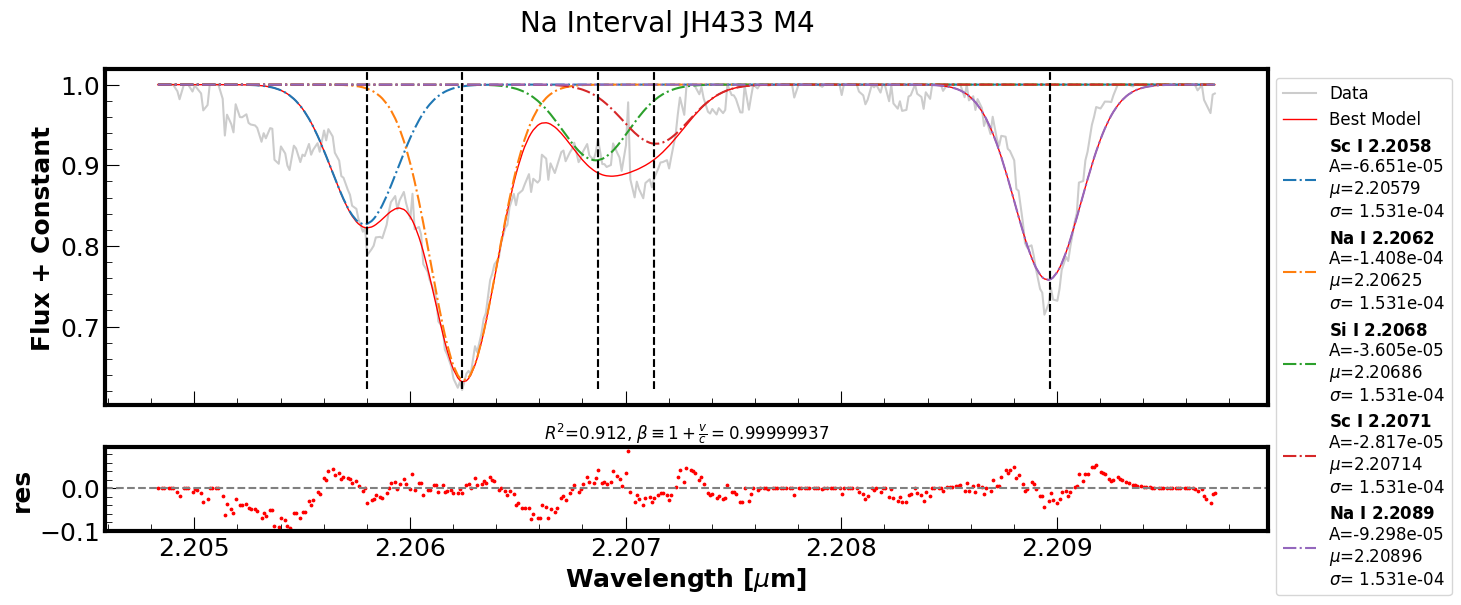

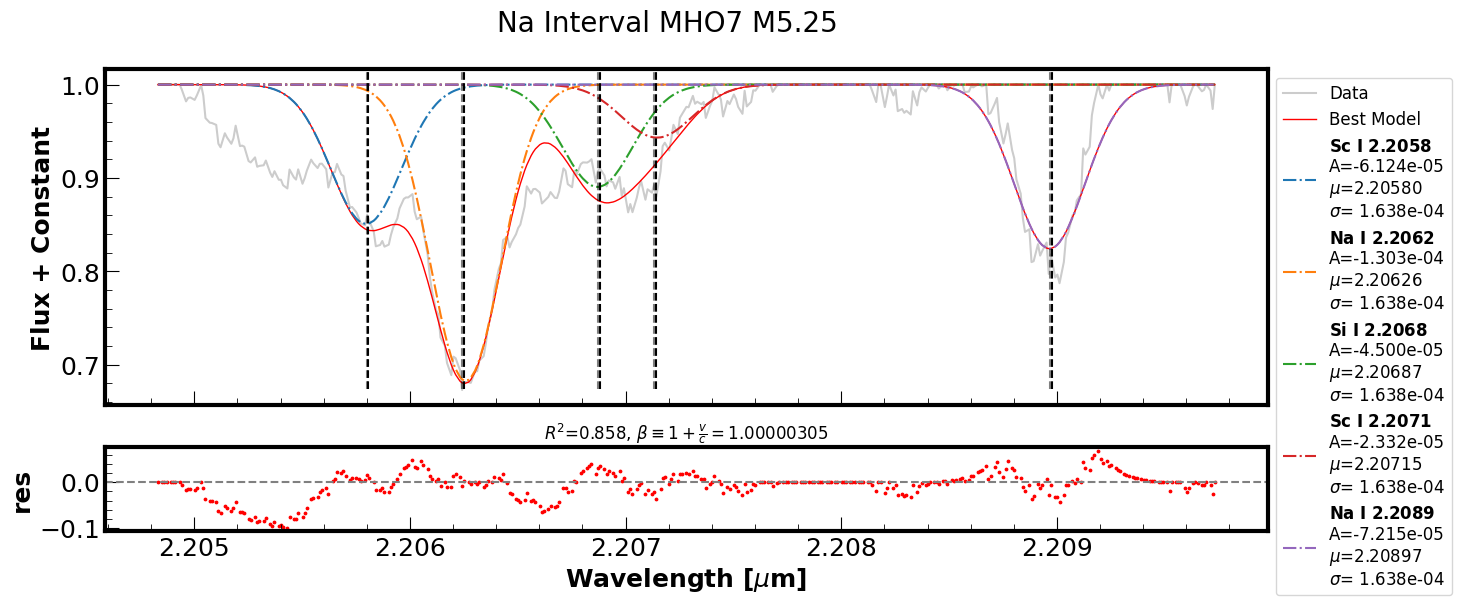

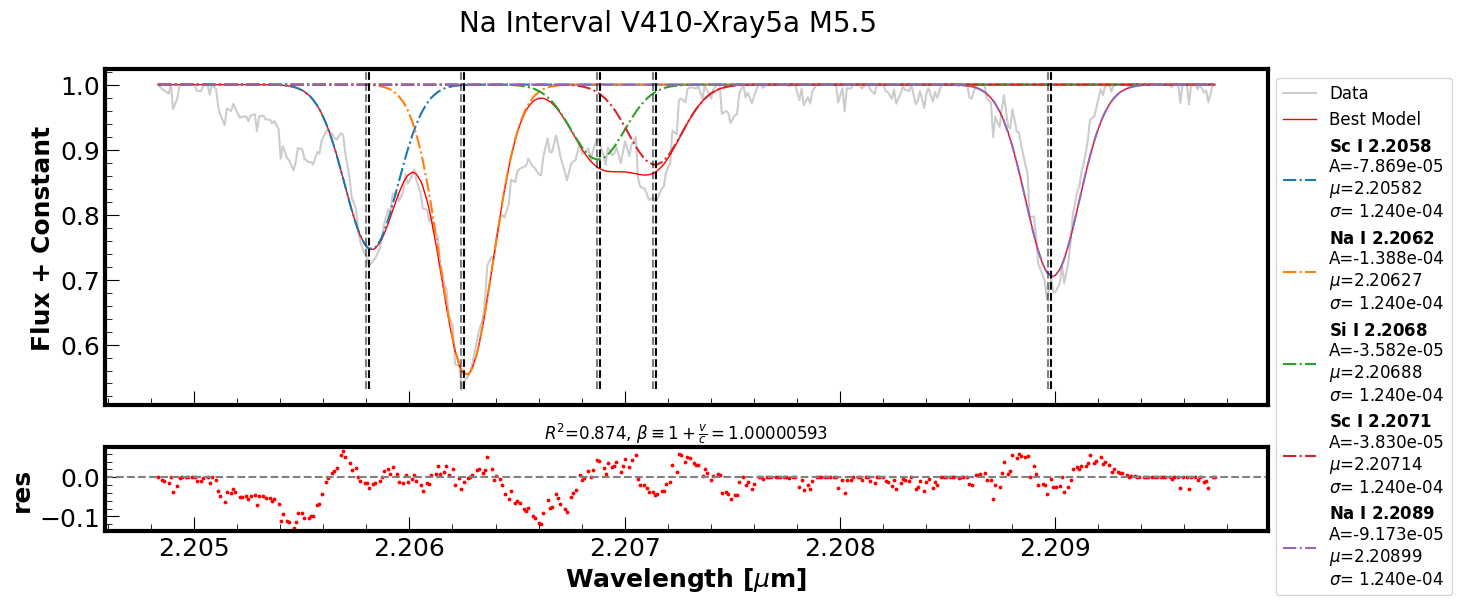

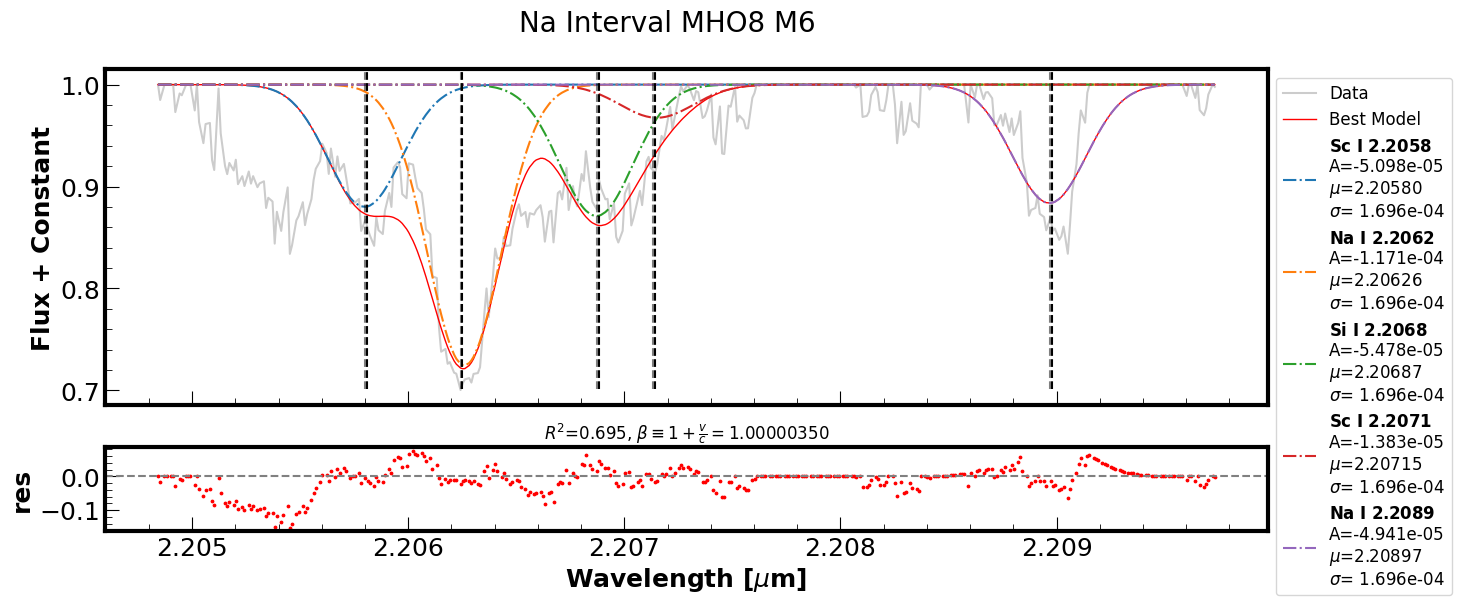

In [40]:
# Initialize storage lists
params_stack = [] # list of best of fit parameters
beta_stack = []
params_error_stack = [] # list of errors on each parameter
best_model_stack = [] # list of best fits to the dats
result_stack = [] # lmfit results
dely_stack = [] # lmfit errors of the fits

for i in range(len(standard_table)):
    # Define initial parameters for Gaussian fitting
    params = Parameters()
    params.add('amp1', value=-1e-5, max=0)
    params.add('c1', value=na_reg_lines[0], min=na_reg_lines[0]-1e-5, max=na_reg_lines[0]+1e-5)
    params.add('std1', value=spec_res)

    params.add('amp2', value=-1e-5, max=0)
    params.add('c2', value=na_reg_lines[1], min=na_reg_lines[1]-1e-5, max=na_reg_lines[1]+1e-5)
    params.add('std2', value=spec_res)

    params.add('amp3', value=-1e-5, max=0)
    params.add('c3', value=na_reg_lines[2], min=na_reg_lines[2]-1e-5, max=na_reg_lines[2]+1e-5)
    params.add('std3', value=spec_res)

    params.add('amp4', value=-1e-5, max=0)
    params.add('c4', value=na_reg_lines[3], min=na_reg_lines[3]-1e-5, max=na_reg_lines[3]+1e-5)
    params.add('std4', value=spec_res)

    params.add('amp5', value=-1e-5, max=0)
    params.add('c5', value=na_reg_lines[4], min=na_reg_lines[4]-1e-5, max=na_reg_lines[4]+1e-5)
    params.add('std5', value=spec_res)

    params.add('beta', value=1.0)

    # mathematical/logic constraints on parameters
    
    # params['c1'].expr = f'{na_reg_lines[0]}'
    # params['c2'].expr = f'{na_reg_lines[1]}'
    # params['c3'].expr = f'{na_reg_lines[2]}'
    # params['c4'].expr = f'{na_reg_lines[3]}'
    # params['c5'].expr = f'{na_reg_lines[4]}'

    # Define the model
    model = Model(ig.five_gaussian_beta, nan_policy='omit')

    # Perform the fit
    result = model.fit(norm_flux_stack[i], params,
                       x=wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i],
                       weights=1 / raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit 
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of: for value in result_stack etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std1'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std1'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std1'].value,
                         result.params['amp5'].value, result.params['c5'].value, result.params['std1'].value])
    beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std1'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std1'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std1'].stderr,
                               result.params['amp5'].stderr, result.params['c5'].stderr, result.params['std1'].stderr])

    best_model_stack.append(result.best_fit)
    # print(result.fit_report())

params_arr = np.array(params_stack)

amps = params_arr[0::3]
amps_err = np.array(params_error_stack)[0::3]

centers = params_arr[1::3]
center_err = np.array(params_error_stack)[1::3]

sigmas = params_arr[2::3]
sigmas_err = np.array(params_error_stack)[2::3]

# Generate the fits for each Gaussian component
na1_2_2062_fit = []
sc1_2_2058_fit = []
si1_2_2068_fit = []
sc1_2_2071_fit = []
na1_2_2089_fit = []

num_gauss = 5

for i in range(len(standard_table)):
    sc1_2_2058_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i]*beta_stack[i], sigmas[0::num_gauss][i]))
    na1_2_2062_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i]*beta_stack[i], sigmas[1::num_gauss][i]))
    si1_2_2068_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i]*beta_stack[i], sigmas[2::num_gauss][i]))
    sc1_2_2071_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i]*beta_stack[i], sigmas[3::num_gauss][i]))
    na1_2_2089_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[4::num_gauss][i], centers[4::num_gauss][i]*beta_stack[i], sigmas[4::num_gauss][i]))

for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], norm_flux_stack[i], c='black', alpha=0.2, label='Data')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], best_model_stack[i], c='red', lw=1, label='Best Model')
    # ax1.errorbar(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], best_model_stack[i], yerr=dely_stack[i],fmt='ro', ms=3, lw=1, label='Best Model')
    
    # ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i],
    #     best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
    #     alpha=0.2, color='red')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], sc1_2_2058_fit[i], ls='-.',
             label=r'$\bf{Sc~I~2.2058}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[0::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], na1_2_2062_fit[i], ls='-.',
             label=r'$\bf{Na~I~2.2062}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], si1_2_2068_fit[i], ls='-.',
             label=r'$\bf{Si~I~2.2068}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
            
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], sc1_2_2071_fit[i], ls='-.',
             label=r'$\bf{Sc~I~2.2071}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], na1_2_2089_fit[i], ls='-.',
             label=r'$\bf{Na~I~2.2089}$' "\n" rf"A={amps[4::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[4::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[4::num_gauss][i]:.3e}")

    for j in range(len(na_reg_lines)):
        ax1.axvline(na_reg_lines[j], ymin=0.05, ymax=1., color='black', ls='--', alpha=0.5)
        ax1.axvline(na_reg_lines[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls='--')
    
    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1, 1), fontsize=12)
    
    # Calculate residuals
    residuals = norm_flux_stack[i] - best_model_stack[i]
    sqsum_res = np.sum(residuals**2)
    sqsum = np.sum((norm_flux_stack[i] - np.mean(norm_flux_stack[i]))**2)
    R2 = 1 - (sqsum_res / sqsum)

    # Plot residuals
    ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    ax2.axhline(y=0, color='grey', linestyle='--')
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf"$R^2$={result_stack[i].rsquared:.3f}, " r'$\beta \equiv 1+\frac{v}{c}= $' f"{beta_stack[i]:.8f}", fontsize=12)
    plt.suptitle(rf"Na Interval {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    
    plt.show()
    # print(result_stack[i].fit_report())

In [27]:
delt_diff_stack = []
ref_line = 4 # reference spectral feature index

for i in range(len(standard_table)):
    # To store the differences for each spectrum
    delta_diff_spectrum = []
    for j in range(len(na_reg_lines)):
        # fit line center and ref line center offset
        fit_ref_diff = np.abs(centers[j::num_gauss][i] - centers[ref_line::num_gauss][i])
        # print(fit_ref_diff)
        # lab line center and ref line center offset
        lab_ref_diff = np.abs(na_reg_lines - na_reg_lines[ref_line])[j]
        # print(lab_ref_diff)
        # difference between the delta wavelengths
        delta_diff = np.abs(fit_ref_diff - lab_ref_diff)
        # print(delta_diff)
        # append to list of differences for spectrum i
        delta_diff_spectrum.append(delta_diff)
        
    # append the differences for this spectrum to the main list
    delt_diff_stack.append(delta_diff_spectrum)
# print(delt_diff_stack)
delt_diff_stack

[[1.828871583642311e-05,
  1.8288786857389994e-05,
  1.7111191636942635e-06,
  1.8288755482931407e-05,
  0.0],
 [1.207845195194679e-05,
  7.921513220043863e-06,
  9.329169119887126e-06,
  1.2078453536013e-05,
  0.0],
 [6.668211770310961e-06,
  3.2837853822798024e-06,
  1.3331593052612334e-05,
  8.655638202181848e-06,
  0.0],
 [1.9223380971045145e-05,
  1.3963575667741424e-05,
  7.765309084639682e-07,
  1.9217645091718083e-05,
  0.0],
 [1.1377724728589556e-05,
  1.9999999911313182e-05,
  9.123324318238701e-11,
  1.9081130657738754e-06,
  0.0],
 [5.288196471386897e-06,
  1.6736077582457654e-05,
  3.263909619910521e-06,
  1.6734032207921246e-05,
  0.0],
 [1.99999999681566e-05,
  1.9999915362944876e-05,
  6.661338147750939e-15,
  1.9996871042149422e-05,
  0.0],
 [1.2123407517439233e-05,
  7.5246982542687135e-06,
  4.201684022930863e-06,
  7.180297253661649e-06,
  0.0],
 [1.8141411000094365e-06,
  1.8142005768773117e-06,
  1.8185776542445353e-05,
  5.35584772620723e-06,
  0.0],
 [9.05745465